In [1]:
%run utils.ipynb

In [2]:
bandwidth = 10E6
pulse_duration = 10E-6
n_pulses = 32

fs =  4 * bandwidth

num_samples = int(np.ceil(pulse_duration * fs))

# wait time in samples
wait_time = num_samples * 19

total_duration = (pulse_duration + wait_time / fs)

t = torch.linspace(0, pulse_duration, num_samples)
# t = torch.cat([t,  torch.zeros((wait_time))])

fc = 1E9

max_unamb_range = c * (total_duration - pulse_duration) / 2
max_unamb_vel = c / (4 * fc * total_duration)
ranges=torch.Tensor([10E3,50E3,100E3])
velocities=torch.Tensor([20,-250,675])
#amplitudes = (torch.Tensor([1,0.2,0.5]) + 1j*torch.Tensor([0,0.9,0.5]))
amplitudes = torch.tensor([1.0, 1.0, 1.0]) * torch.exp(1j * torch.normal(0,1, ranges.shape))

print(f'Total Duration:{total_duration}')
print(f'Unambiguous Range:{max_unamb_range}')
print(f'Unambiguous Vel:{max_unamb_vel}')

torch.fmod(ranges,max_unamb_range), torch.fmod(velocities, max_unamb_vel)

Total Duration:0.000200475
Unambiguous Range:28551.484218775
Unambiguous Vel:373.8526724030428


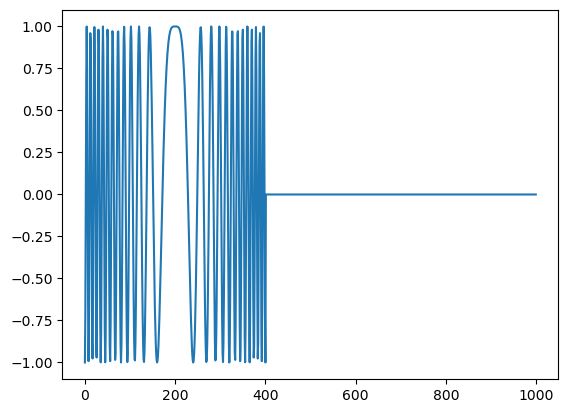

In [21]:
signal = generate_waveform(bandwidth, pulse_duration, n_pulses, t, wait_time)

nfft_range = 2 * signal.shape[1] - 1
nfft_doppler = 1024

scene = make_scene(amplitudes,ranges,velocities,max_unamb_range,max_unamb_vel,nfft_range,nfft_doppler)

plt.plot(torch.real(signal[0, :1000]))

SNR Loss: 0.0 dB


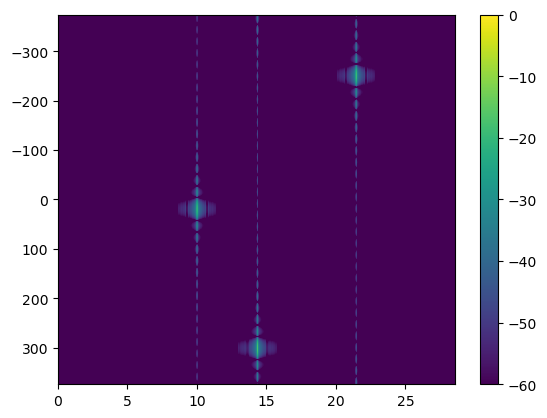

In [4]:
coherent_gain = int(np.ceil(pulse_duration * fs)) * signal.shape[-2]

coherent_gain_db =  20*torch.log10(torch.Tensor([coherent_gain]))

X = simulate_target_with_scene_profile(signal, scene,num_pulses=32)

RDout = 20*torch.log10(1E-16 + torch.abs(doppler_processing(signal, X, nfft_range, nfft_doppler)))
RDout =  RDout - coherent_gain_db

print(f'SNR Loss: {torch.max(RDout)} dB')
plt.imshow(RDout[0,:,nfft_range//2:],aspect='auto',extent=[0, max_unamb_range * 1E-3, max_unamb_vel,-max_unamb_vel])
plt.clim(-60,0)
plt.colorbar()
# plt.xlim(9,11)
# plt.ylim(0,50)

SINR: -69.2396240234375


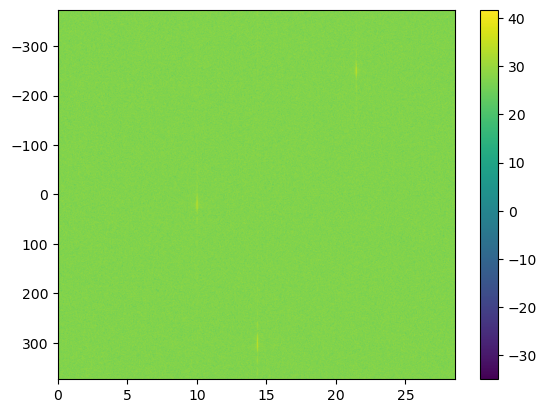

In [13]:
image = doppler_processing(signal, X, nfft_range, nfft_doppler)
noise = torch.normal(0,1000,image.shape)
SINR = SNR(image, noise)

print(f'SINR: {SINR}')
image = torch.abs(image +  noise)

plt.imshow(10 * torch.log10(image)[0,:,nfft_range//2:],aspect='auto',extent=[0, max_unamb_range * 1E-3, max_unamb_vel,-max_unamb_vel])
# plt.clim(20, 40)
plt.colorbar()

Range Resolution: 1.7801286999672672 meters
Doppler Resolution: 0.3650905003935965 m/s
Alpha: 0.036632928437698054
Probability of detection: 1.000534176826477


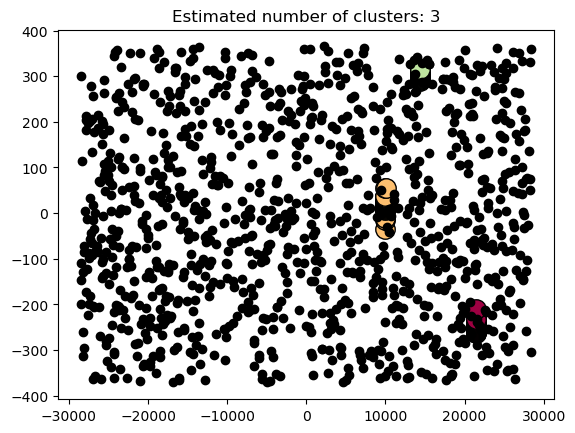

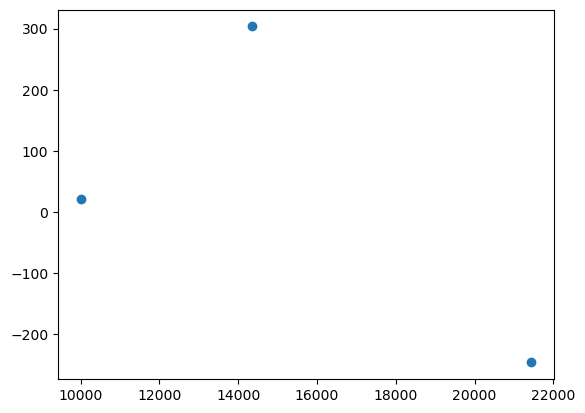

[(21444.180297634193, -246.66835635499876),
 (9997.755484926147, 21.433544706594382),
 (14341.406819698237, 303.4927683851133),
 (nan, nan)]

In [16]:
image = image.reshape(1, 1, nfft_doppler, nfft_range)
r_res = max_unamb_range / nfft_range
v_res = max_unamb_vel / nfft_doppler
print(f'Range Resolution: {r_res} meters')
print(f'Doppler Resolution: {v_res} m/s')

k_width = int(np.ceil(r_res)) * 16
k_height = int(np.ceil(v_res)) * 10

P_FA = 10e-6
K = k_width * k_height
alpha = P_FA ** (-1 / K) -1
P_D = (1 + ((alpha / K) / (1 + SINR))) ** -K
print(f'Alpha: {alpha}')
print(f'Probability of detection: {P_D}')


CFAR(image, k_width, k_height, alpha=5, plot=True)